In [4]:

import json
import pandas as pd


def read_json_to_dataframe(file_path):
  """Reads the JSON file and convert only the 'results' node into a DataFrame.

  Args:
    file_path: The path to the JSON file.

  Returns:
    A pandas DataFrame containing the data from the 'results' node.
  """

  with open(file_path, 'r') as f:
    data = json.load(f)

  if 'results' in data:
    return pd.DataFrame(data['results'])
  else:
    return pd.DataFrame()  # Return an empty DataFrame if 'results' node is not found.


file_path = 'data/food-enforcement.json'  # Replace with the actual path
df = read_json_to_dataframe(file_path)

df = df.dropna(subset=['classification'])

# drop columns openfda	product_type	event_id

columns_to_drop = ['openfda', 'product_type', 'event_id']

df = df.drop(columns=columns_to_drop, errors='ignore')

#null or yet to be classified are considered outliers
valid_classifications = ['Class I', 'Class II', 'Class III']
df = df[df['classification'].isin(valid_classifications)]

# Convert specified columns to datetime
date_columns = ['recall_initiation_date', 'center_classification_date', 'report_date', 'termination_date']
for col in date_columns:
     df[col] = pd.to_datetime(df[col], errors='coerce')


# Infer data types and convert columns
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors='ignore')
    elif pd.api.types.is_datetime64_any_dtype(df[col]):
        continue  # Skip datetime columns
    else:
        # Convert to categorical for object types if cardinality is below a threshold
        if df[col].nunique() / len(df) < 0.5: # Adjust threshold as needed
            df[col] = df[col].astype('category')
        else:
            df[col] = df[col].astype(str) # Convert to strings for other object types

# determine the time taken to recall from the report date
df['lag_days'] = (df['center_classification_date'] - df['recall_initiation_date']).dt.days

# Define keywords and their corresponding categories
keywords = {
    'bacterial': ['contaminated','coli', 'contamination', 'salmonella', 'listeria','presence'],
    'foreign objects': ['metal', 'plastic', 'foreign', 'glass','aluminium','tin','iron'],
    'mislabeled': ['label','declare','misbranded','exceed','specification'],
    'process': ['violation','license', 'inspect','level','process','unsafe','appropriate','infestation'],
    'allergens':['allerg']

}

# Function to classify reasons
def classify_reason(reason):
    reason = str(reason).lower() # Convert reason to lower case for case-insensitive matching
    for category, words in keywords.items():
        for word in words:
          if word.lower() in reason:
              return category
    return 'other'

# Apply the classification function to create a new 'classification' column
df['reason'] = df['reason_for_recall'].apply(classify_reason)


df.to_csv('data/food-enforcement.csv', index=False)
df.info()
df.head()


<ipython-input-4-e183f56ce097>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-4-e183f56ce097>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-4-e183f56ce097>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

<class 'pandas.core.frame.DataFrame'>
Index: 27137 entries, 0 to 27137
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   status                      27137 non-null  category      
 1   city                        27137 non-null  category      
 2   state                       27137 non-null  category      
 3   country                     27137 non-null  category      
 4   classification              27137 non-null  category      
 5   recalling_firm              27137 non-null  category      
 6   address_1                   27137 non-null  category      
 7   address_2                   27137 non-null  category      
 8   postal_code                 27137 non-null  category      
 9   voluntary_mandated          27137 non-null  category      
 10  initial_firm_notification   27137 non-null  category      
 11  distribution_pattern        27137 non-null  category      


,status,city,state,country,classification,recalling_firm,address_1,address_2,postal_code,voluntary_mandated,...,product_quantity,reason_for_recall,recall_initiation_date,center_classification_date,report_date,code_info,more_code_info,termination_date,lag_days,reason
0,Completed,Cicero,IL,United States,Class II,ZB Importing LLC,5400 W 35th St,,60804-4431,Voluntary: Firm initiated,...,433 cases,Milk not declared as the major food allergen s...,2025-02-15,2025-03-13,2025-03-19,L07 04/2025 and L11 EXP 11/2025,,NaT,26.0,mislabeled
1,Ongoing,Walnut Creek,CA,United States,Class II,"Del Monte Foods, Inc",205 N Wiget Ln,,94598-2403,Voluntary: Firm initiated,...,"8,242cases (24cans/case)",Foreign Object,2025-02-12,2025-03-13,2025-03-19,"Best if Used By 28 OCT 2026, Lot 7AA 418507",,NaT,29.0,foreign objects
2,Completed,Cicero,IL,United States,Class II,ZB Importing LLC,5400 W 35th St,,60804-4431,Voluntary: Firm initiated,...,145 cases,Milk not listed in Contains statement,2025-02-15,2025-03-13,2025-03-19,"L09 EXP 04/2025, L11 EXP 05/2025 and L07 EXP 0...",,NaT,26.0,other
3,Completed,Cicero,IL,United States,Class II,ZB Importing LLC,5400 W 35th St,,60804-4431,Voluntary: Firm initiated,...,482 cases,Egg not listed in Contains statement,2025-02-15,2025-03-13,2025-03-19,"L06 EXP 03/2025, L07 EXP 03/2025 and L11 EXP 0...",,NaT,26.0,other
4,Ongoing,San Antonio,TX,United States,Class II,HEB,646 S Flores St,,78204-1219,Voluntary: Firm initiated,...,45lbs,Potential metal inclusion,2025-02-09,2025-03-13,2025-03-19,Spinach Artichoke Dip Sold Hot 200000509996 Pa...,,NaT,32.0,foreign objects


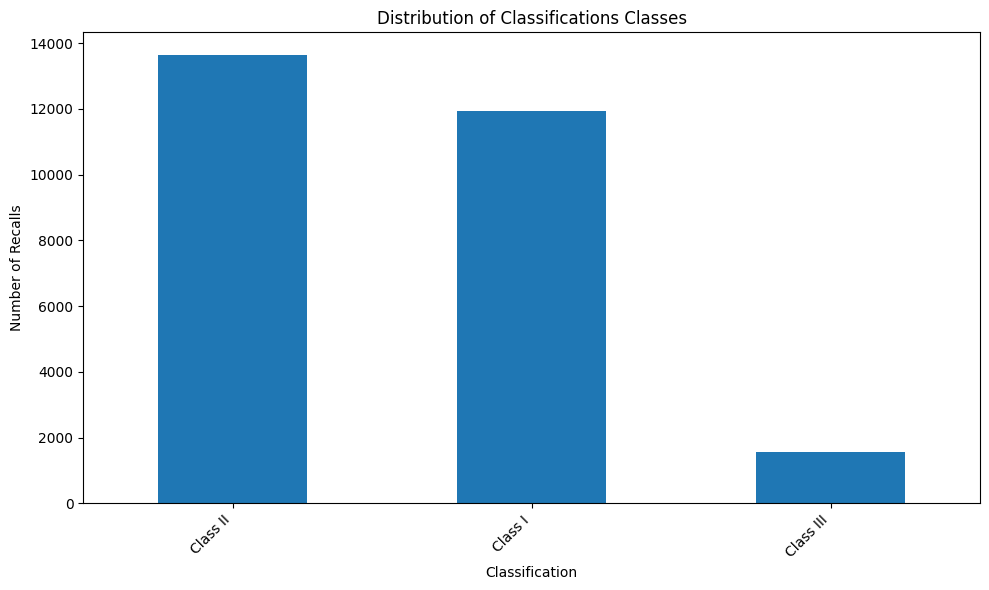

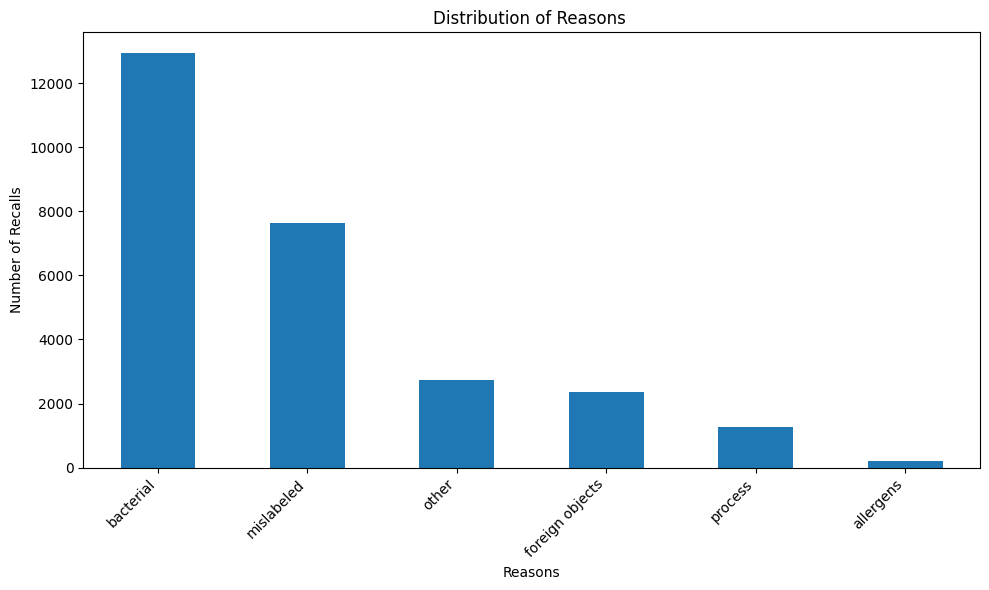

In [5]:

import matplotlib.pyplot as plt


# Create the histogram for Classification Classes
plt.figure(figsize=(10, 6))
df['classification'].value_counts().plot(kind='bar')
plt.title('Distribution of Classifications Classes')
plt.xlabel('Classification')
plt.ylabel('Number of Recalls')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Create the histogram for Reason
plt.figure(figsize=(10, 6))
df['reason'].value_counts().plot(kind='bar')
plt.title('Distribution of Reasons ')
plt.xlabel('Reasons')
plt.ylabel('Number of Recalls')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


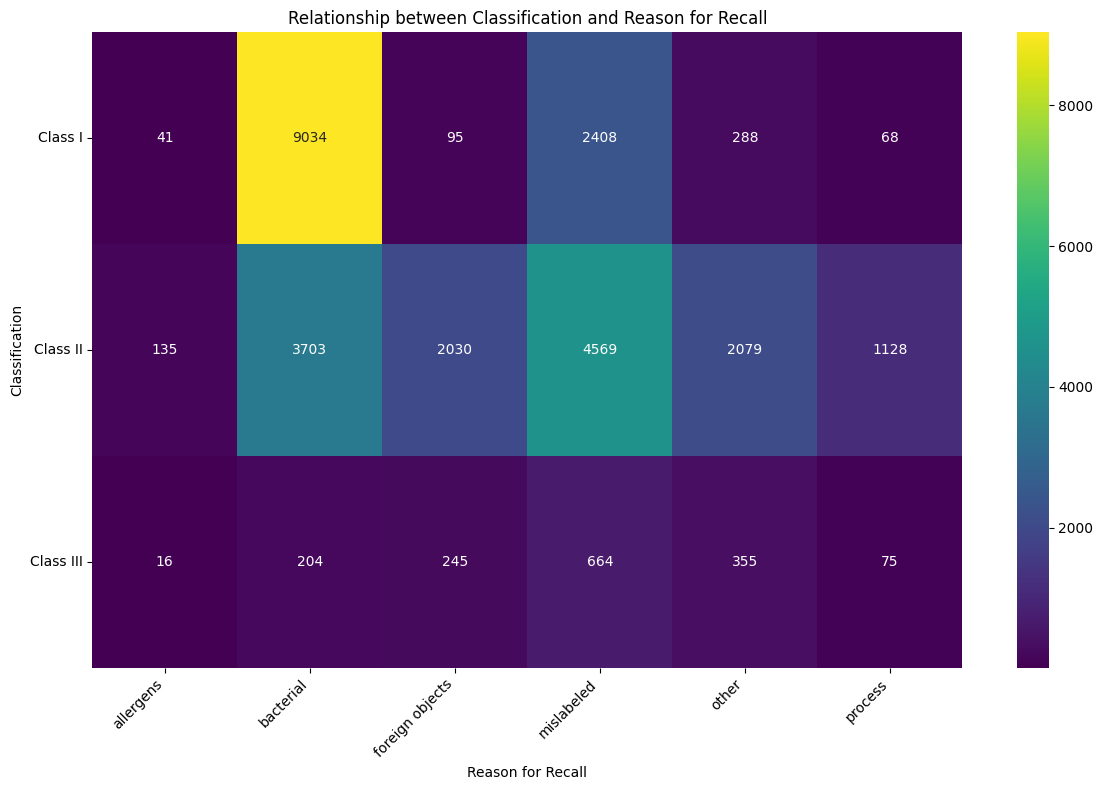

In [6]:
import seaborn as sns

# Create a cross-tabulation between 'classification' and 'reason'
classification_reason_counts = pd.crosstab(df['classification'], df['reason'])

# Plotting the cross-tabulation as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(classification_reason_counts, annot=True, fmt='d', cmap='viridis')
plt.title('Relationship between Classification and Reason for Recall')
plt.xlabel('Reason for Recall')
plt.ylabel('Classification')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


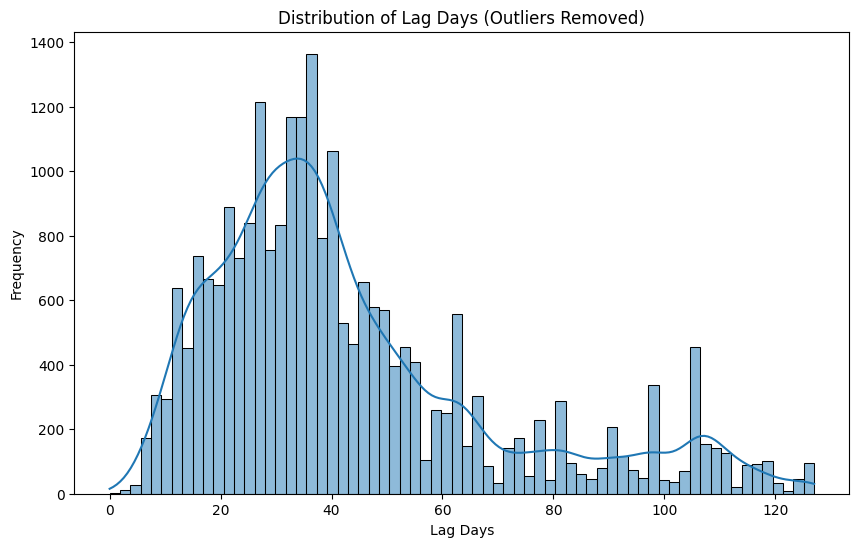

In [7]:


# Calculate the IQR for lag_days
Q1 = df['lag_days'].quantile(0.25)
Q3 = df['lag_days'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier removal
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_filtered = df[(df['lag_days'] >= lower_bound) & (df['lag_days'] <= upper_bound)]

# Create the lag days graph without outliers
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['lag_days'], kde=True)  # Use histplot for better visualization
plt.title('Distribution of Lag Days (Outliers Removed)')
plt.xlabel('Lag Days')
plt.ylabel('Frequency')
plt.show()


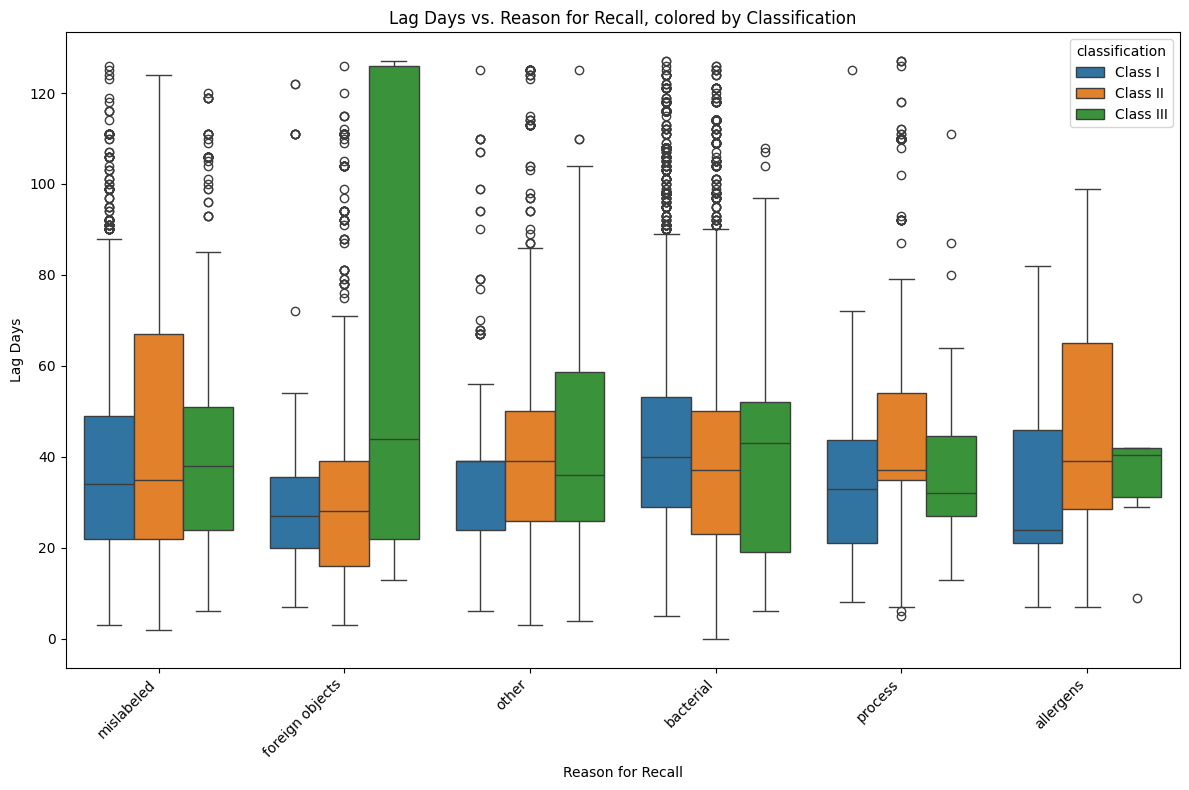

In [8]:

plt.figure(figsize=(12, 8))
sns.boxplot(x='reason', y='lag_days', hue='classification', data=df_filtered)
plt.title('Lag Days vs. Reason for Recall, colored by Classification')
plt.xlabel('Reason for Recall')
plt.ylabel('Lag Days')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


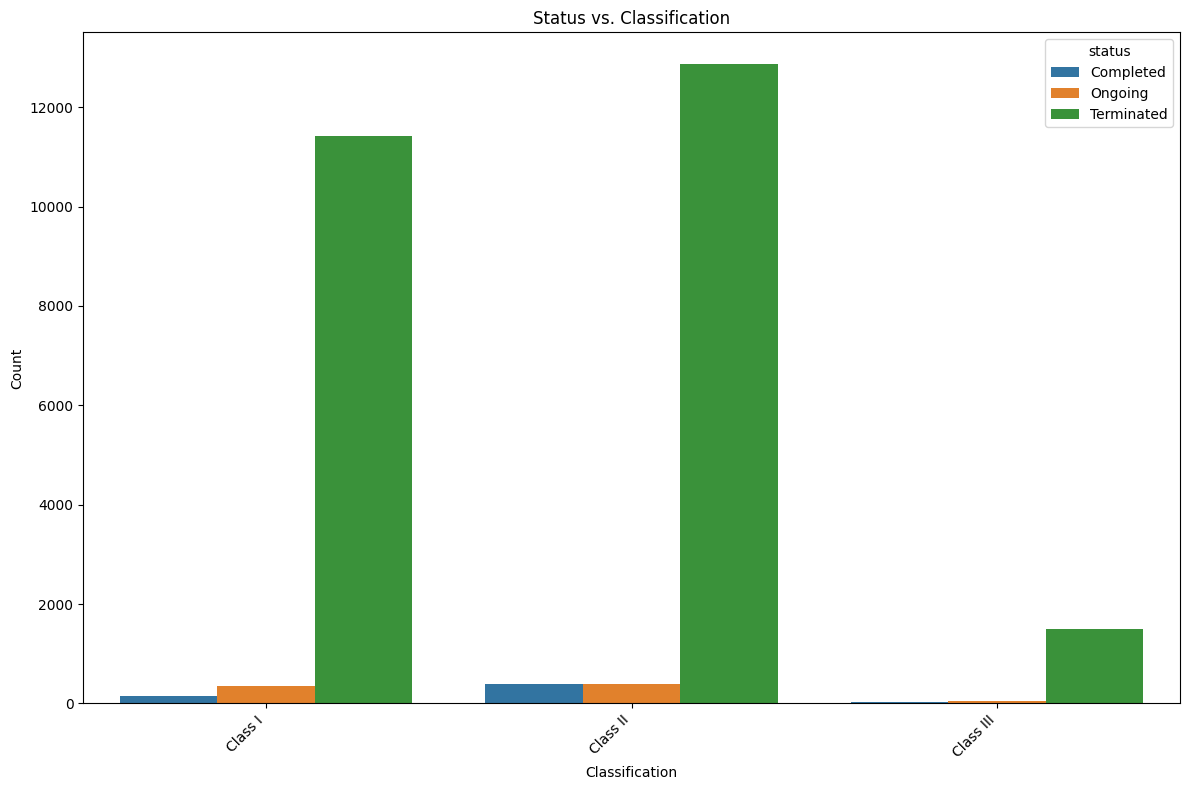

In [9]:

plt.figure(figsize=(12, 8))
sns.countplot(x='classification', hue='status', data=df)
plt.title('Status vs. Classification')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Accuracy: 0.815033161385409
              precision    recall  f1-score   support

     Class I       0.86      0.82      0.83      2401
    Class II       0.78      0.88      0.83      2718
   Class III       0.86      0.23      0.36       309

    accuracy                           0.82      5428
   macro avg       0.83      0.64      0.67      5428
weighted avg       0.82      0.82      0.81      5428



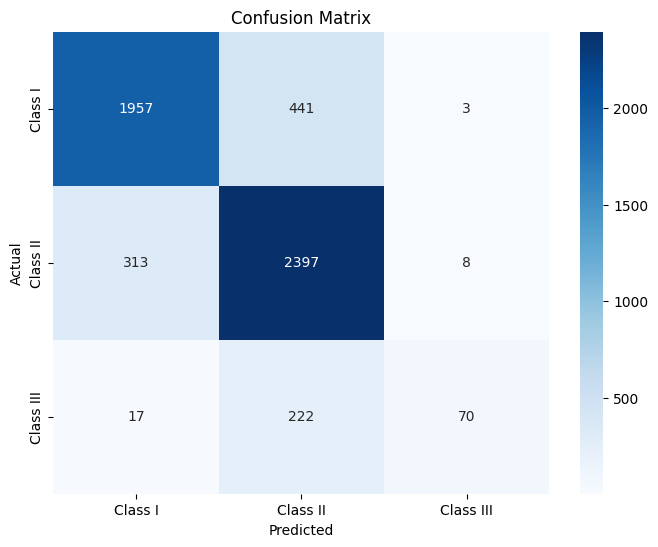

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare the data for the Naive Bayes model
X = df['reason_for_recall']  # Read the reason for recall
y = df['classification']  # Use 'classification' as the target variable

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

